In [1]:
from PyQt5.sip import assign
from plydata.cat_tools import cat_inorder
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

--2024-10-13 22:33:37--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K   917KB/s    in 1.1s    

2024-10-13 22:33:40 (917 KB/s) - ‘bank+marketing.zip’ saved [1023843]



In [2]:
from unicodedata import numeric

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from plotnine import *

In [6]:
bank_subscription_df = pd.read_csv('../../data/03-week/bank/bank-full.csv',delimiter=';')


In [7]:
bank_subscription_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
required_cols = ["age","job","marital","education","balance","housing","contact","day","month","duration","campaign","pdays","previous","poutcome","y"]

In [10]:
bank_subscription_df = bank_subscription_df[required_cols]

In [11]:
bank_subscription_df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## Question 1

In [14]:
bank_subscription_df.education.value_counts(normalize=True)

education
secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: proportion, dtype: float64

In [16]:
bank_subscription_df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [21]:
numerical_val = ['age','balance','day','duration','campaign','pdays','previous']

In [92]:
categorial_val = ['job','marital','education','housing','contact','month','poutcome']

## Question 2

In [25]:
long_format_corr = bank_subscription_df[numerical_val].corr()

In [24]:
import plydata.cat_tools as cat 

In [54]:
tidy_corr = long_format_corr\
    .melt(
        ignore_index=False
    )\
    .reset_index()\
    .set_axis(
        labels = ['var1','var2','value'],
        axis = 1 
    )\
    .assign(
        label_text = lambda x:np.round(x['value'],2)
    )\
    .assign(
        var1 = lambda x:cat.cat_inorder(x['var1']),
      var2 = lambda x:cat.cat_inorder(x['var2'],ordered = True),
)\
    .assign(
        
)

In [63]:
list_ordering = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [71]:
tidy_corr["var2"] = tidy_corr["var2"].cat.set_categories(list_ordering,ordered=False)

In [79]:
tidy_corr = tidy_corr\
    .sort_values(['var2'],ascending = [False])

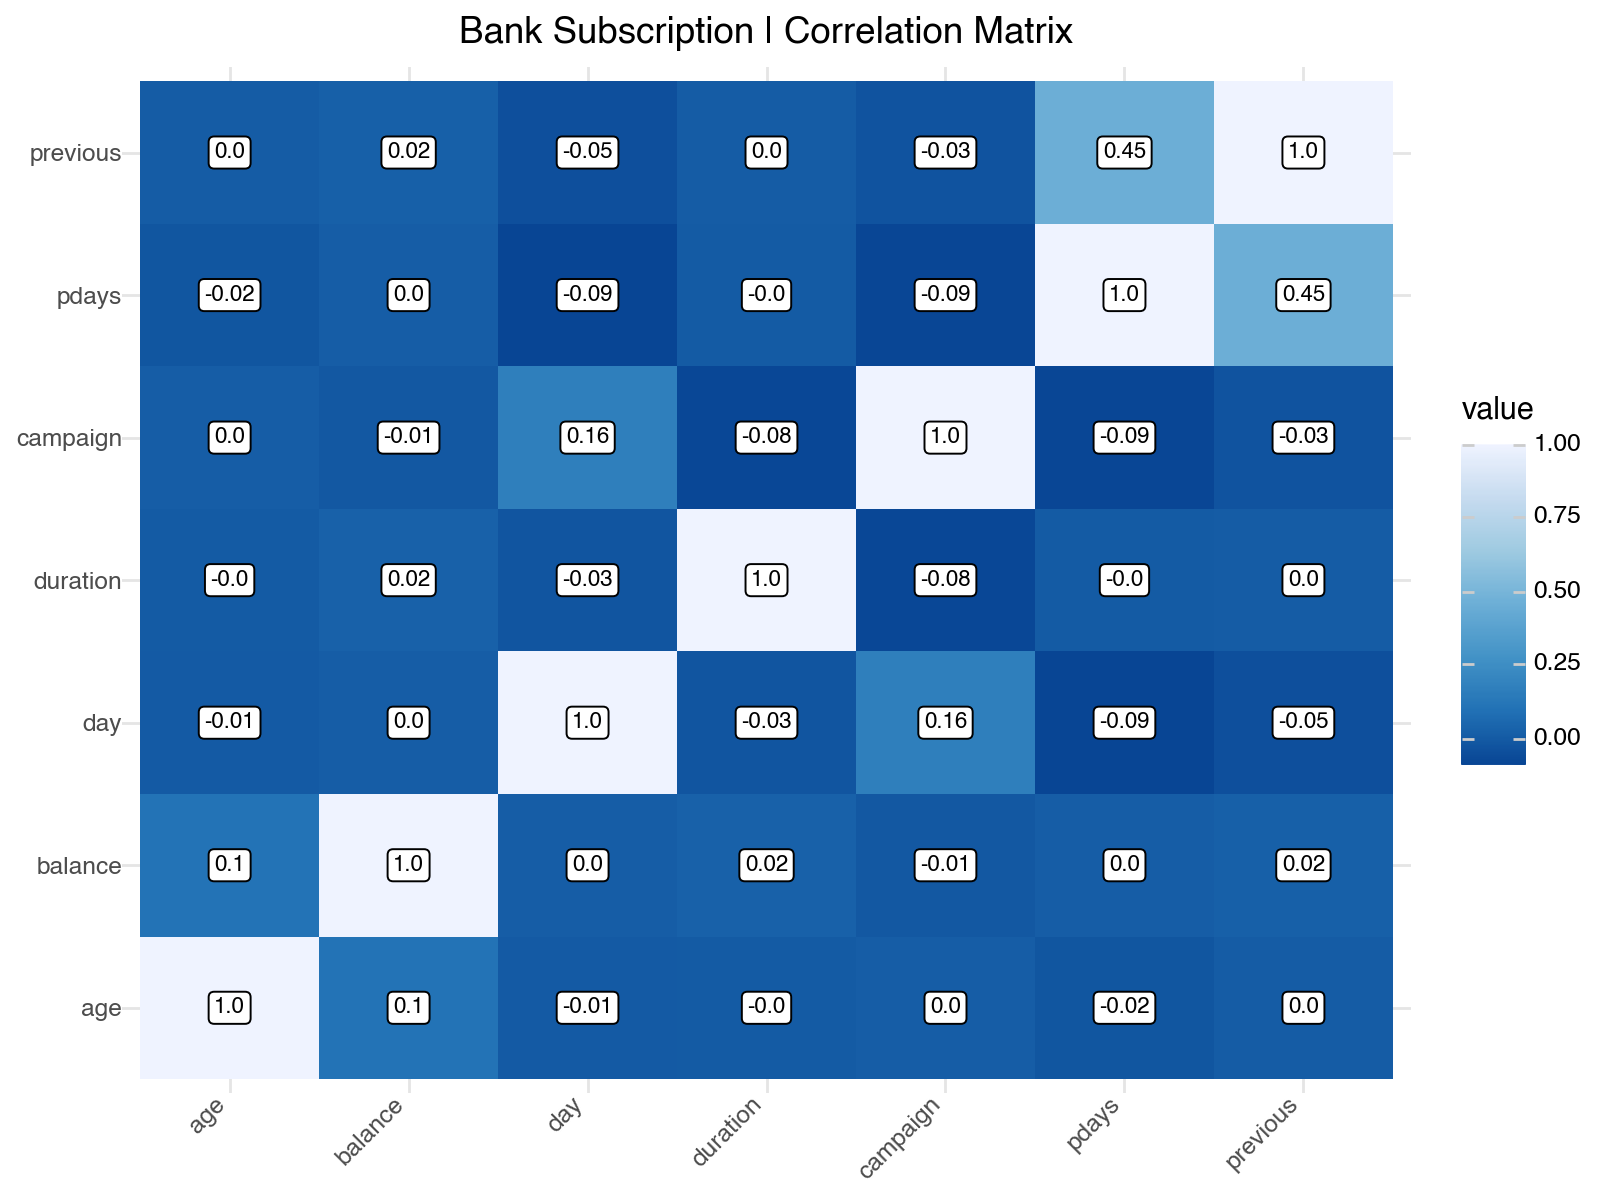

In [80]:
(ggplot(
        mapping = aes ("var1", "var2", fill = "value"),
        data= tidy_corr)
    + geom_tile() 
    + geom_label(aes (label = "label_text"),
                 fill ="white",size = 8) 
    + scale_fill_distiller() 
    + theme_minimal()
    + labs(
        title ="Bank Subscription | Correlation Matrix",
        x = "", y = "")
    +theme(axis_text_x= element_text (rotation=45, hjust = 1),
           figure_size=(8,6))
)

In [82]:
bank_subscription_df['y'] = (bank_subscription_df['y']=='yes').astype(int)

In [83]:
bank_subscription_df['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

## Split training and testing 

In [84]:
from sklearn.model_selection import train_test_split

In [86]:
bank_subscription_full_train, bank_subscription_test = train_test_split(bank_subscription_df,test_size=0.2,random_state=1)
bank_subscription_train,bank_subscription_val = train_test_split(bank_subscription_full_train,test_size=0.25,random_state=1)

In [87]:
print(len(bank_subscription_train)) 
print(len(bank_subscription_val))
print(len(bank_subscription_test))

27126
9042
9043


In [89]:
bank_subscription_train = bank_subscription_train.reset_index(drop=True)
bank_subscription_val = bank_subscription_val.reset_index(drop=True)
bank_subscription_test = bank_subscription_test.reset_index(drop=True)


y_train = bank_subscription_train.y.values
y_val = bank_subscription_val.y.values
y_test = bank_subscription_test.y.values

bank_subscription_train.drop('y',axis = 1,inplace=True)
bank_subscription_val.drop('y',axis = 1,inplace=True)
bank_subscription_test.drop('y',axis = 1,inplace=True)


## Question 3


In [90]:
from sklearn.metrics import mutual_info_score

In [96]:
def mutual_info_churn_score(series):
    return mutual_info_score(series,y_train)

In [97]:
bank_subscription_train[categorial_val].apply(mutual_info_churn_score).sort_values(ascending=False)

poutcome     0.028586
month        0.024460
contact      0.012256
housing      0.009158
job          0.008130
education    0.002461
marital      0.002042
dtype: float64

## Question 4

In [98]:
train_dict = bank_subscription_train[categorial_val + numerical_val].to_dict(orient='records')

In [99]:
from sklearn.feature_extraction import DictVectorizer

In [100]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)


In [101]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [102]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [103]:
val_dict = bank_subscription_val[categorial_val + numerical_val].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]  ## soft prediction


In [104]:
subcription_decision = (y_pred >=0.5)

In [106]:
np.round((y_val==subcription_decision.astype(int)).mean(),2)

0.9

In [120]:
original = (y_val==subcription_decision.astype(int)).mean()

In [121]:
print(original)

0.8979208139792081


## Question 5 

In [107]:
categoril_remove = ["age","balance","marital","previous"]

In [108]:
categorial_accur = dict()

In [123]:
features_list = categorial_val + numerical_val

In [129]:
for cat in categoril_remove:
    print(cat)
    subset = features_list.copy()
    subset.remove(cat)
    
    train_dict = bank_subscription_train[subset].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train,y_train)
    val_dict = bank_subscription_val[subset].to_dict(orient='records')
    X_val = dv.fit_transform(val_dict)
    y_pred = model.predict_proba(X_val)[:,1]
    subcription_decision = (y_pred >=0.5)
    categorial_accur[cat] = (y_val==subcription_decision.astype(int)).mean() - original
    


age
balance
marital
previous


In [130]:
categorial_accur

{'age': 0.0,
 'balance': 0.0005529750055297544,
 'marital': 0.00033178500331787486,
 'previous': 0.0}

## Question 6 

In [131]:
cat_dict = dict()
for c in [0.01, 0.1, 1, 10, 100]:
    print(c)
    train_dict = bank_subscription_train[features_list].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train,y_train)
    val_dict = bank_subscription_val[features_list].to_dict(orient='records')
    X_val = dv.fit_transform(val_dict)
    y_pred = model.predict_proba(X_val)[:,1]
    subcription_decision = (y_pred >=0.5)
    cat_dict[str(c)] = (y_val==subcription_decision.astype(int)).mean()
    

0.01
0.1
1
10
100


In [135]:
dict(sorted(cat_dict.items(), key=lambda item: item[1],reverse=True))

{'10': 0.8981420039814201,
 '1': 0.8980314089803141,
 '100': 0.8979208139792081,
 '0.1': 0.8971466489714665,
 '0.01': 0.8946029639460297}